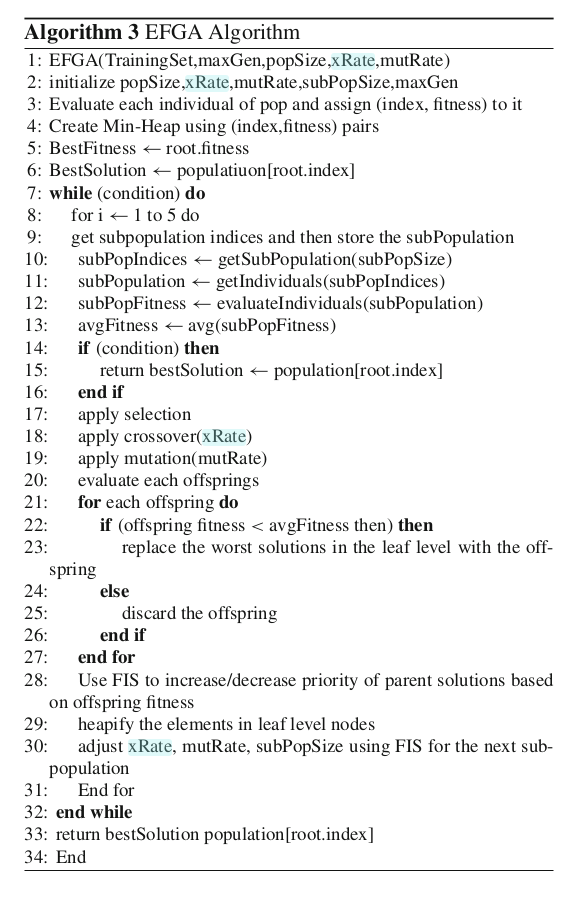

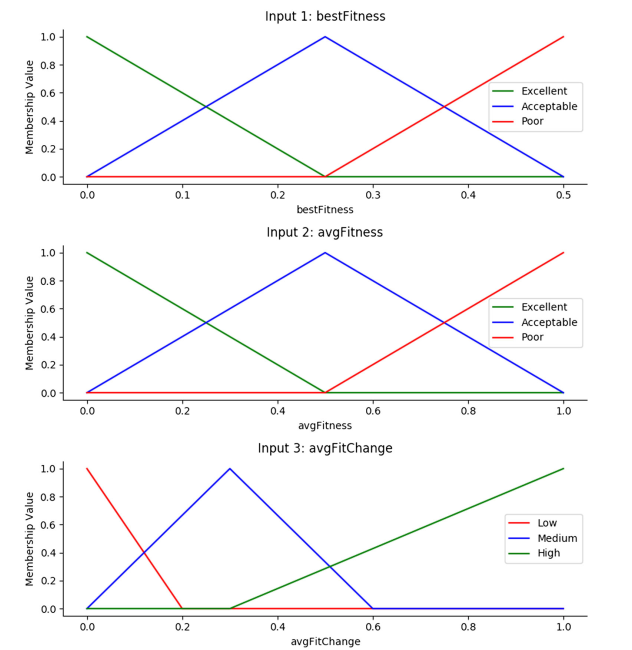
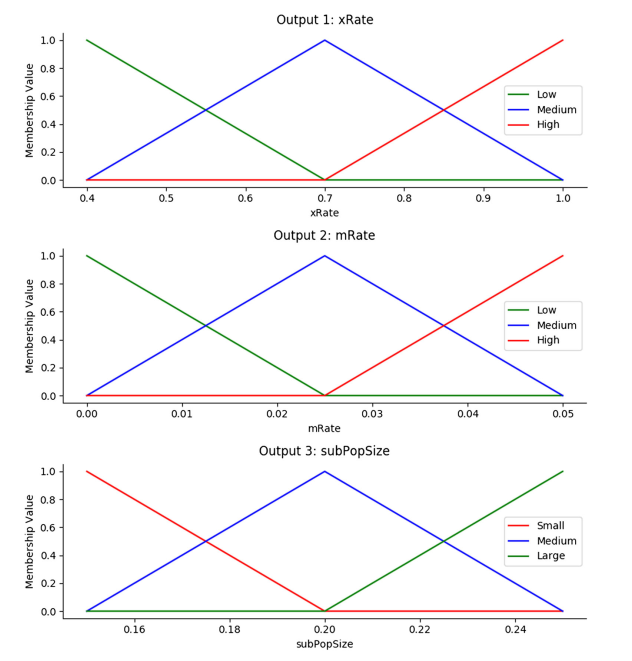

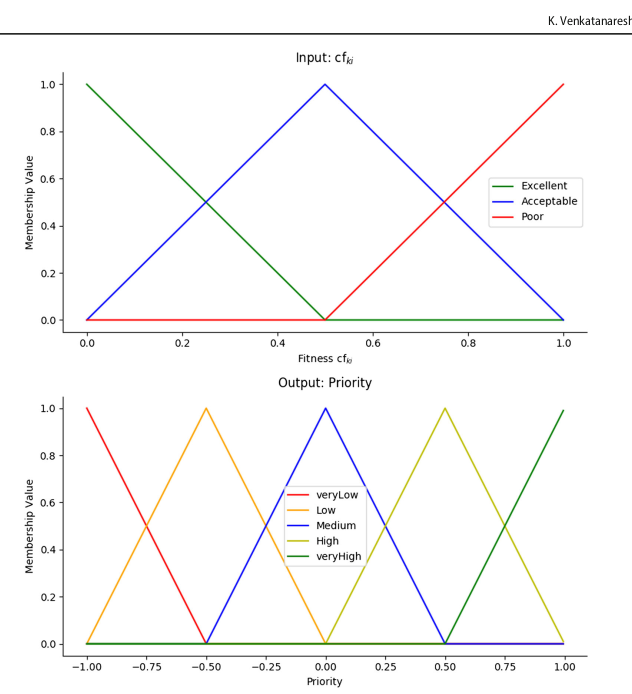


TODO: 
1) Implement minheap and test it - Done
2) Minimization relative fitness value (let's say that we have error, how do we calculate fitness value) - Done
3) Implement fuzzy sets for: bestFitness, xRate,mutRate, subPopSize, priority: very low-very high - Done
4) Implement fuzzy rules. - Done. 
5) Implement crossover
6) Implement mutation


In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


from src.common.experiment_runners import run_experiments_efga, run_experiments_gendered
from src.common.visualization import visualize_efga, visualize_gendered
from src.common.fitness import griewank, rastrigin, ackley

## Schwefel function

### EFGA

In [3]:
output_params = 'log/schwefel_efga_params_parallel.json'
output_experiment_logs = 'log/schwefel_experiment_efga_logs_parallel.csv'
experiment_logs, params = run_experiments_efga(n_experiments=5, epochs=500, N=500)


with open(output_params, 'w') as f:
    json.dump(params, f)

experiment_logs.to_csv(output_experiment_logs)


100%|██████████| 5/5 [04:36<00:00, 55.35s/it]


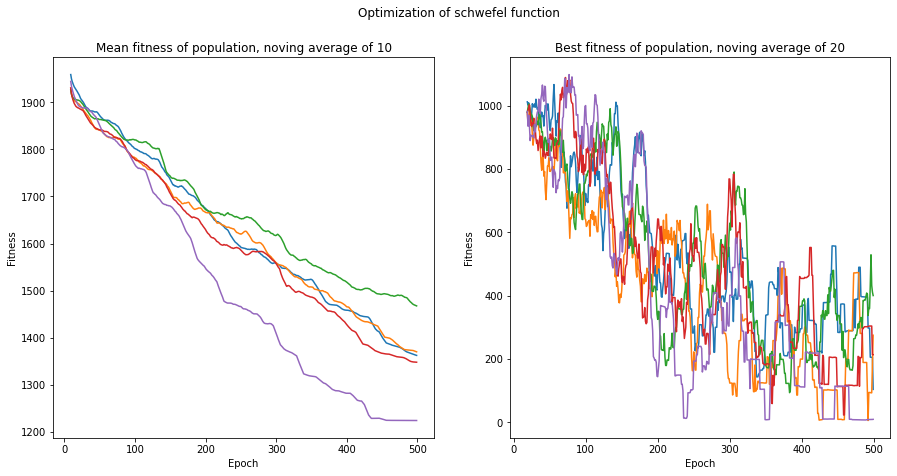

In [4]:
visualize_efga(experiment_logs, windowsize_best=20, function_name='schwefel function')


In [4]:
experiment_logs.groupby('seed').first()['ncalls'].mean(), experiment_logs.groupby('seed').first()['ncalls'].median()

(33449.6, 33166.0)

### Gendered selection

In [2]:
output_params = 'log/schwefel_gendered_params_parallel.json'
output_experiment_logs = 'log/schwefel_gendered_logs_parallel.csv'
experiment_logs, params = run_experiments_gendered(n_experiments=5, epochs=100, population_scale=500, mutation_scale=.5, N=150)

with open(output_params, 'w') as f:
    json.dump(params, f)

experiment_logs.to_csv(output_experiment_logs)
experiment_logs, params

  0%|          | 0/5 [00:00<?, ?it/s]


TypeError: ParallelInferrer.multiprocessing_preferred_age() got an unexpected keyword argument 'diversity'

In [2]:
experiment_logs, params = pd.read_csv('log/schwefel_gendered_logs.csv'), json.load(open('log/schwefel_gendered_params.json', 'r'))

In [3]:
experiment_logs.seed.unique()

array([0, 1, 2, 3, 4])

In [4]:
experiment_logs[experiment_logs.seed == 4]

,Unnamed: 0,avg_fitness,best_fitness,population_size,epoch,ncalls,seed
400,0,2160.568346,1056.730868,174,0,16203,4
401,1,2121.469544,956.676724,201,1,16203,4
402,2,2069.253584,937.724305,231,2,16203,4
403,3,2012.076274,930.504316,251,3,16203,4
404,4,1992.760353,938.034472,258,4,16203,4
...,...,...,...,...,...,...,...
495,95,613.386982,428.512098,98,95,16203,4
496,96,609.186307,428.356089,103,96,16203,4
497,97,606.733567,426.399172,102,97,16203,4
498,98,589.059540,425.931230,98,98,16203,4


wqehwe
wqehwe
wqehwe
wqehwe
wqehwe


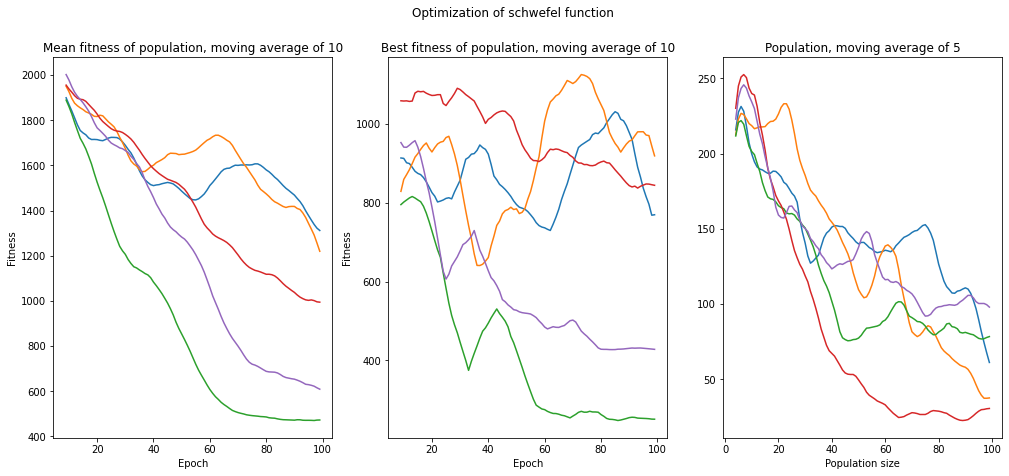

In [5]:
visualize_gendered(history=experiment_logs, function_name='schwefel function')

In [10]:
experiment_logs.groupby('seed').first()['ncalls'].mean(), experiment_logs.groupby('seed').first()['ncalls'].median()

(14648.6, 15986.0)

## Griewank function

### EFGA

In [2]:
output_params = 'log/griewank_efga_params.json'
output_experiment_logs = 'log/griewank_experiment_efga_logs.csv'
experiment_logs, params = run_experiments_efga(n_experiments=5, epochs=500, fitness_fn=griewank, population_scale=600, mutation_scale=.2)


with open(output_params, 'w') as f:
    json.dump(params, f)

experiment_logs.to_csv(output_experiment_logs)

100%|██████████| 5/5 [04:24<00:00, 52.85s/it]


In [3]:
experiment_logs, params = pd.read_csv('log/griewank_experiment_efga_logs.csv'), json.load(open('log/griewank_efga_params.json', 'r'))

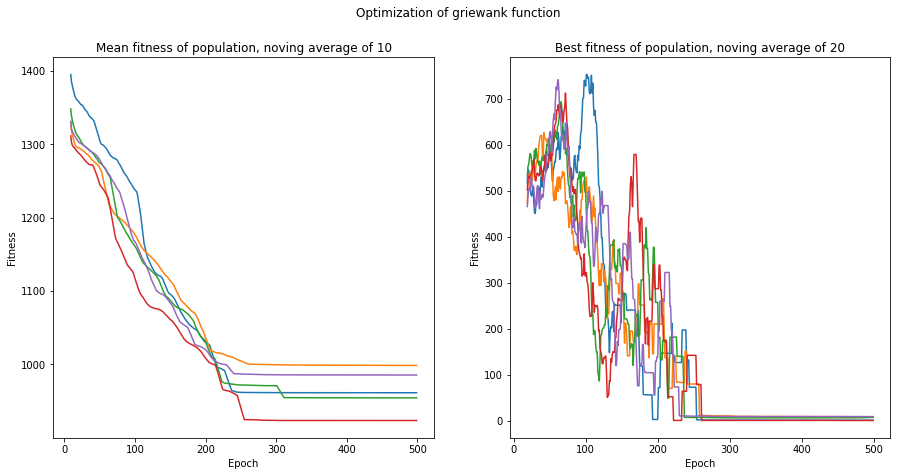

(27773.2, 27812.0)

In [4]:
visualize_efga(experiment_logs, windowsize_best=20, function_name='griewank function')
experiment_logs.groupby('seed').first()['ncalls'].mean(), experiment_logs.groupby('seed').first()['ncalls'].median()


### Gendered selection

In [5]:
output_params = 'log/griewank_gendered_params.json'
output_experiment_logs = 'log/griewank_experiment_gendered_logs.csv'
experiment_logs, params = run_experiments_gendered(n_experiments=5, epochs=100, population_scale=600, mutation_scale=.5, N=150, fitness_fn=griewank)


with open(output_params, 'w') as f:
    json.dump(params, f)

experiment_logs.to_csv(output_experiment_logs)

100%|██████████| 5/5 [02:34<00:00, 30.92s/it]


wqehwe
wqehwe
wqehwe
wqehwe
wqehwe


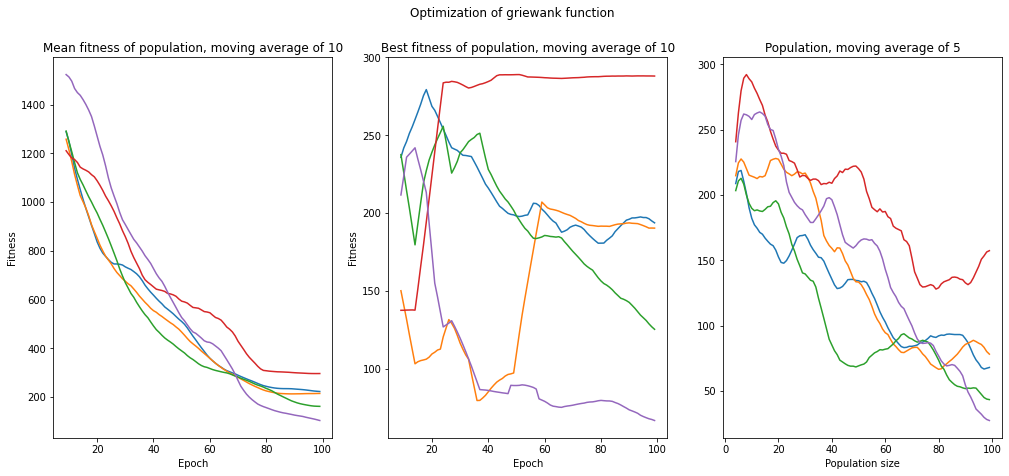

In [6]:
visualize_gendered(history=experiment_logs, function_name='griewank function')

## Rastrigin function

### EFGA

In [3]:
output_params = 'log/rastrigin_efga_params.json'
output_experiment_logs = 'log/rastrigin_experiment_efga_logs.csv'
experiment_logs, params = run_experiments_efga(n_experiments=5, epochs=500, population_scale=5.12, mutation_scale=.05, fitness_fn=rastrigin)


with open(output_params, 'w') as f:
    json.dump(params, f)

experiment_logs.to_csv(output_experiment_logs)


100%|██████████| 5/5 [05:14<00:00, 62.98s/it]


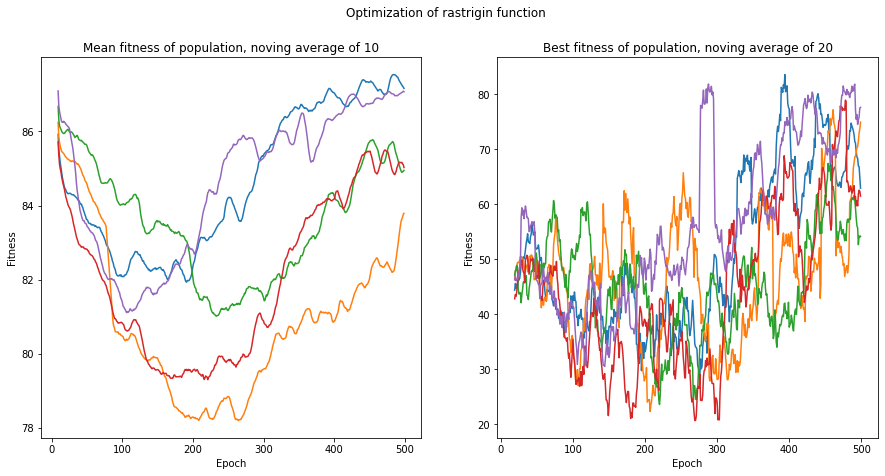

In [4]:
visualize_efga(experiment_logs, windowsize_best=20, function_name='rastrigin function'), 


In [5]:
experiment_logs.groupby('seed').first()['ncalls'].mean(), experiment_logs.groupby('seed').first()['ncalls'].median()

(35438.0, 35422.0)

### Gendered selection

In [6]:
output_params = 'log/rastrigin_gendered_params.json'
output_experiment_logs = 'log/rastrigin_experiment_gendered_logs.csv'
experiment_logs, params = run_experiments_gendered(n_experiments=5, epochs=100, population_scale=5.12, mutation_scale=.05, N=150, fitness_fn=rastrigin)


with open(output_params, 'w') as f:
    json.dump(params, f)

experiment_logs.to_csv(output_experiment_logs)

100%|██████████| 5/5 [10:53<00:00, 130.62s/it]


wqehwe
wqehwe
wqehwe
wqehwe
wqehwe


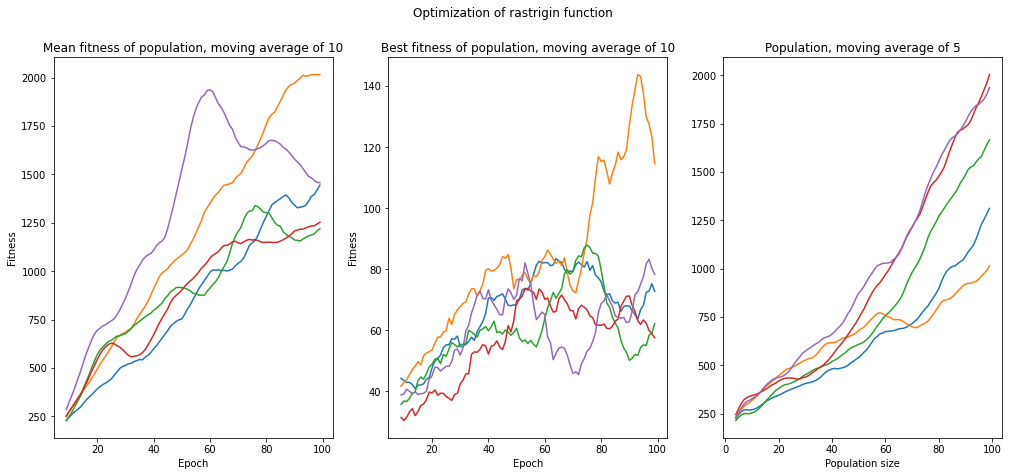

(None, 90031.4)

In [9]:
visualize_gendered(history=experiment_logs, function_name='rastrigin function'), experiment_logs.groupby('seed').first(
    'ncalls'
)['ncalls'].mean()

## Ackley function

### EFGA

In [2]:
output_params = 'log/ackley_efga_params.json'
output_experiment_logs = 'log/ackley_experiment_efga_logs.csv'
experiment_logs, params = run_experiments_efga(n_experiments=5, epochs=500, fitness_fn=ackley, population_scale=32, mutation_scale=.05)


with open(output_params, 'w') as f:
    json.dump(params, f)

experiment_logs.to_csv(output_experiment_logs)

100%|██████████| 5/5 [06:51<00:00, 82.23s/it]


In [6]:
experiment_logs, params = pd.read_csv('log/ackley_experiment_efga_logs.csv'), json.load(open('log/ackley_efga_params.json', 'r'))

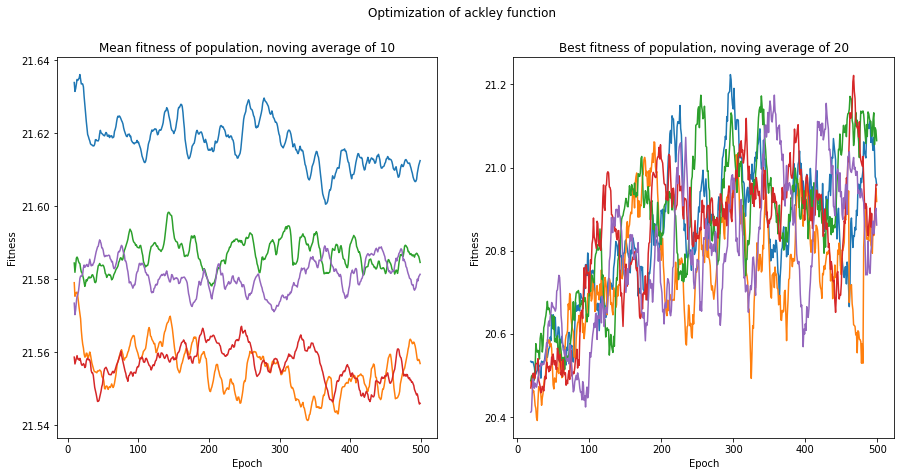

(43514.8, 43510.0)

In [7]:
visualize_efga(experiment_logs, windowsize_best=20, function_name='ackley function')
experiment_logs.groupby('seed').first()['ncalls'].mean(), experiment_logs.groupby('seed').first()['ncalls'].median()


### Gendered selection

In [8]:
output_params = 'log/ackley_gendered_params.json'
output_experiment_logs = 'log/ackley_experiment_gendered_logs.csv'
experiment_logs, params = run_experiments_gendered(n_experiments=5, epochs=100, fitness_fn=ackley, population_scale=32, mutation_scale=.05, N=150)


with open(output_params, 'w') as f:
    json.dump(params, f)

experiment_logs.to_csv(output_experiment_logs)

 20%|██        | 1/5 [00:19<01:16, 19.20s/it]

Early stopping at epoch: 86, population died


 60%|██████    | 3/5 [00:47<00:30, 15.04s/it]

Early stopping at epoch: 95, population died


100%|██████████| 5/5 [01:17<00:00, 15.59s/it]


wqehwe
wqehwe
wqehwe
wqehwe
wqehwe


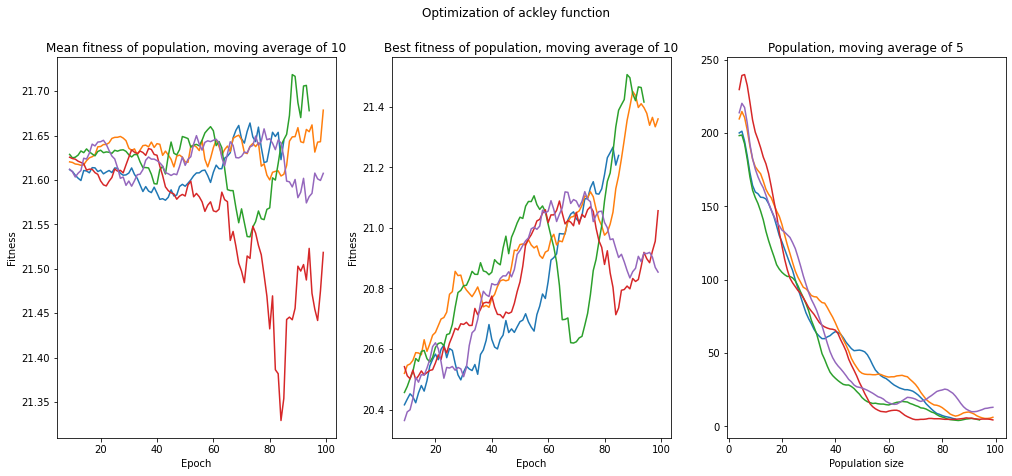

(None, 7387.8)

In [9]:
visualize_gendered(history=experiment_logs, function_name='ackley function'), experiment_logs.groupby('seed').first(
    'ncalls'
)['ncalls'].mean()